In [7]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.dates import AutoDateLocator
loc10 = plticker.MultipleLocator(base=10)

# Data Quality EDA

## Questions for March 9th

1. Is the data work just a matter of filling gaps in the WB, WIOD, OECD, WHO data?
2. What are the target countries/timespans we're looking to model? (Sam mentioned Brazil but in WB, Brazil seems data poor)
3. Are there data types that aren't covered in the current documentations? (e.g. household size)
4. Is there a natural/heuristic way to prioritize the need for empirical fitting? (i.e. What agent-traits can we assume to be normally distributed, etc.?)


## World Bank Data

In [8]:
f = h5py.File('./sample_data/world_bank.h5', 'r')
print("Keys: %s" % list(f.keys()))
a_group_key = list(f.keys())[0]
a_group_key

wb_dict = {}
for i in f.keys():
    wb_dict[i] = pd.read_hdf('./sample_data/world_bank.h5', key=i)

Keys: ['birth_rates', 'cpi', 'gdp', 'govt_debt', 'historic_cpi', 'historic_gdp', 'interest_rates', 'long_term_ir', 'participation', 'short_term_ir', 'tau_exp', 'tau_vat', 'unemployment']


In [9]:
def wb_missing_time(d):

    years_str = [str(i) for i in range(1960, 2021)]
    years = list(range(1960, 2021))
    fig, axes = plt.subplots(1,1)

    for key, df in d.items():
        if not key in ['historic_gdp', 'historic_cpi', 'long_term_ir', 'short_term_ir']:
            axes.plot(years, np.sum(~df[years_str].isna()) / 266, label=key)
        elif not key in ['long_term_ir', 'short_term_ir']:
            axes.plot(years, np.sum(~df.T[years].isna()) / 266, label=key)
            
    axes.xaxis.set_major_locator(loc10)
    axes.legend(bbox_to_anchor=(1, 1))
    axes.set_title('% of Countries (N=266) with Data - World Bank')
    plt.show()

def wb_missing_ir(d):

    both = set(d['short_term_ir']['LOCATION']).intersection(d['long_term_ir']['LOCATION'])

    d['short_term_ir']['YEAR'] = [i[0:4] for i in d['short_term_ir']['TIME']]
    d['long_term_ir']['YEAR'] = [i[0:4] for i in d['long_term_ir']['TIME']]

    short_df = d['short_term_ir'][['LOCATION', 'YEAR']].drop_duplicates().sort_values('YEAR').copy()
    long_df = d['long_term_ir'][['LOCATION', 'YEAR']].drop_duplicates().sort_values('YEAR').copy()

    fig, axes = plt.subplots(1,2,figsize=(10, 8))

    y_ticks = []
    y_labels = []

    for i, c in enumerate(list(both)):

        y_ticks.append(i)
        y_labels.append(c)

        temp_df = short_df[short_df['LOCATION'] == c]
        axes[0].scatter([int(y) for y in temp_df['YEAR']], [i for n in temp_df['YEAR']], label=c)
        
        temp_df = long_df[long_df['LOCATION'] == c]
        axes[1].scatter([int(y) for y in temp_df['YEAR']], [i for n in temp_df['YEAR']], label=c)

    axes[0].set_title('Short-term IR')
    axes[0].set_yticks(y_ticks)
    axes[0].set_yticklabels(y_labels)
    axes[0].plot([1990, 1990], [0,41])
    axes[1].set_title('Long-term IR')
    axes[1].set_yticks(y_ticks)
    axes[1].set_yticklabels(y_labels)
    axes[1].plot([1990, 1990], [0,41])
    fig.suptitle('IR Data Points Exist')

Assuming we use only data after 1990, the biggest data gaps exist for participation, tau_vat, tau_exp, govt_debt, and interest_rates.

Note: historic_gdp == gdp and historic_cpi == cpi.

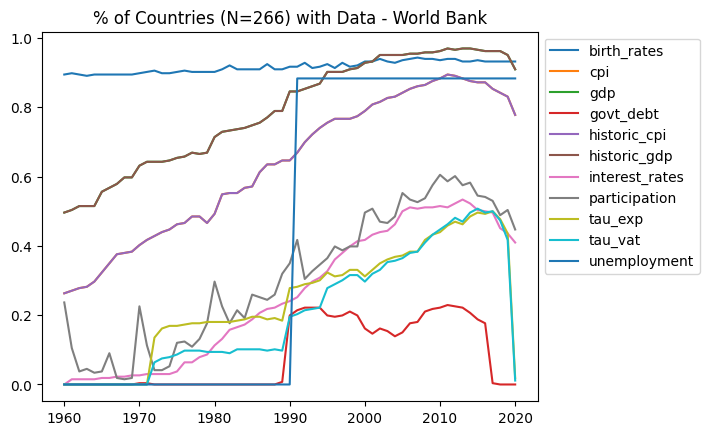

In [10]:
wb_missing_time(wb_dict)

### Countries with Complete IR Data after 1990

1. New Zealand (NZL)
2. Austria (AUT)
3. Belgium (BEL)
4. United States (USA)
5. Netherlands (NLD)
6. Sweden (SWE)
7. Findland (FIN)
8. Australia (AUS)
9. Canada (CAN)
10. Ireland (IRL)
11. South Africa (ZAF)
12. United Kingdom (GBR)
13. Spain (ESP)
14. France (FRA)
15. Germany (DEU)
16. Denmark (DNK)
17. Norway (NOR)

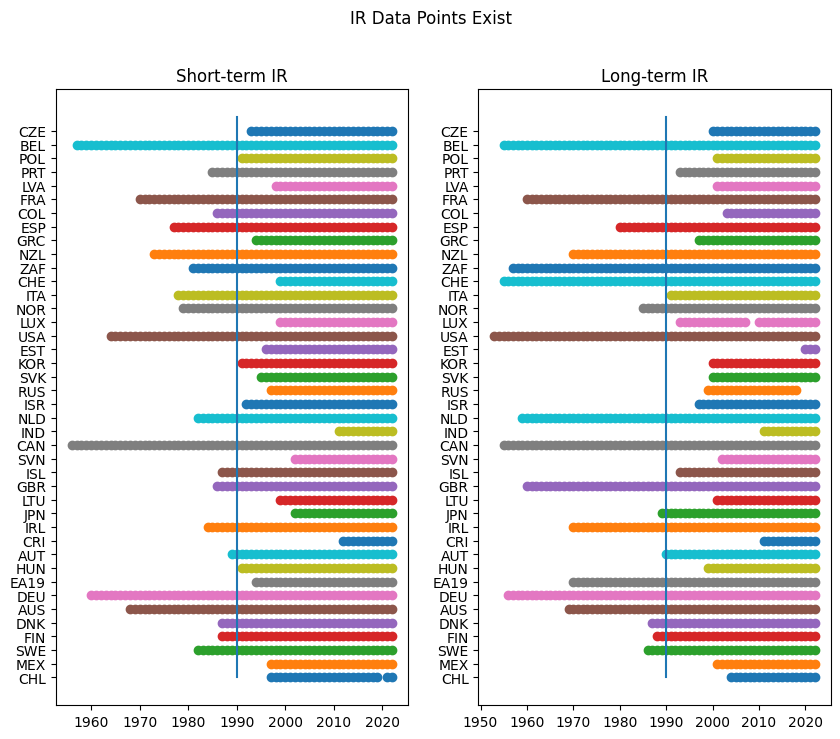

In [11]:
wb_missing_ir(wb_dict)

## Most Data Rich Countries in World Bank Data since 1991

1. Austria (AUS)
4. South Africa (ZAF) - worst is participation (missing 2)
2. United States (USA) - worst is tau_vat (missing 7)
3. United Kingdom (GBR) - worst is interest_rates (missing 6)
5. Netherlands (NLD) - worst is interest_rates (missing 15)

In [12]:
ir_data_rich = ['NZL','AUT','BEL','USA','NLD','SWE','FIN','AUS','CAN','IRL','ZAF','GBR','ESP','FRA','DEU','DNK','NOR']
years_str = [str(i) for i in range(1991, 2021)]
rows = []

for country in ir_data_rich:
    row = {}
    row['country'] = country
    row['total'] = 0
    for key, df in wb_dict.items():
        # gdp and cpi are equivalent and govt_debt unimportant according to documentation
        if not key in ['historic_gdp', 'historic_cpi', 'long_term_ir', 'short_term_ir', 'govt_debt']: 
            row[key] =  np.sum(df[df.index == country][years_str].isna(), axis=1).values[0]
            row['total'] += np.sum(df[df.index == country][years_str].isna(), axis=1).values[0]
    rows.append(row)

pd.DataFrame(rows).sort_values('total')

,country,total,birth_rates,cpi,gdp,interest_rates,participation,tau_exp,tau_vat,unemployment
7,AUS,3,0,0,0,1,0,1,1,0
10,ZAF,4,0,0,0,0,2,1,1,0
3,USA,7,0,0,0,0,0,0,7,0
11,GBR,9,0,0,0,6,1,1,1,0
4,NLD,17,0,0,0,15,0,1,1,0
5,SWE,17,0,0,0,15,0,1,1,0
16,NOR,24,0,0,0,22,0,1,1,0
14,DEU,32,0,0,0,30,0,1,1,0
13,FRA,32,0,0,0,30,0,1,1,0
0,NZL,32,0,0,0,9,0,11,12,0


## WIOD Data

## OECD Data

## WHO Data

In [13]:
accounts_df  = pd.read_csv('sample_data/Socio_Economic_Accounts.csv')

In [16]:
f = h5py.File('./sample_data/oecd_econ_data.h5', 'r')
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]
a_group_key

oecd_dict = {}
for i in f.keys():
    oecd_dict[i] = pd.read_hdf('./sample_data/oecd_econ_data.h5', key=i)

oecd_dict['business_birth_rates']

Keys: <KeysViewHDF5 ['business_birth_rates', 'business_death_rates', 'business_demography', 'employment_by_industry', 'tau_firm', 'tau_inc', 'tau_sif', 'tau_siw', 'total_benefits', 'unemployment_benefits']>


,LOCATION,Country,IND,Variable,SEC,ISIC4,SCL,Size Class,TIME,Time,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2008,2008,PC,Percentage,0,Units,NaN,NaN,9.4,NaN,NaN
1,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2009,2009,PC,Percentage,0,Units,NaN,NaN,9.3,NaN,NaN
2,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2010,2010,PC,Percentage,0,Units,NaN,NaN,8.9,NaN,NaN
3,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2011,2011,PC,Percentage,0,Units,NaN,NaN,9.1,NaN,NaN
4,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2012,2012,PC,Percentage,0,Units,NaN,NaN,8.7,NaN,NaN
5,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2013,2013,PC,Percentage,0,Units,NaN,NaN,9.2,NaN,NaN
6,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2014,2014,PC,Percentage,0,Units,NaN,NaN,8.9,NaN,NaN
7,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2015,2015,PC,Percentage,0,Units,NaN,NaN,8.6,NaN,NaN
8,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2016,2016,PC,Percentage,0,Units,NaN,NaN,8.7,NaN,NaN
9,AUT,Austria,B_R_EMPL,Birth rate of employer enterprises,05_82_LESS_642,"Total industry, construction and market servic...",TOTAL,Total,2017,2017,PC,Percentage,0,Units,NaN,NaN,8.4,NaN,NaN
